# Time series prediction

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import SimpleRNN
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import GRU
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [2]:
dataset = pd.read_csv('airline-passengers.csv', usecols=[1], engine='python')
dataset

,Passengers
0,112
1,118
2,132
3,129
4,121
...,...
139,606
140,508
141,461
142,390


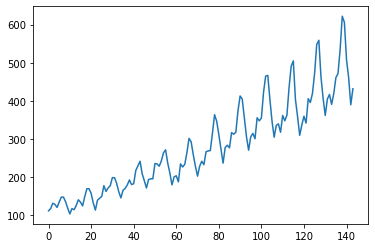

In [3]:
# Time plot
plt.plot(dataset)
plt.show()

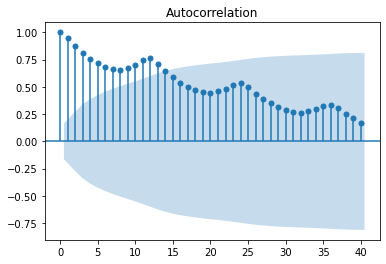

In [4]:
# Auto-Correlation Function & Partial Auto-Correlation Function Plots

plot_acf(dataset.Passengers, lags=40)
# Show the AR as a plot
plt.show()

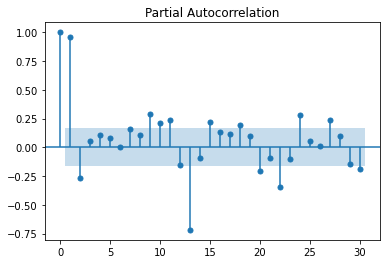

In [5]:
plot_pacf(dataset.Passengers, lags=30)
# Show the PAR as a plot
plt.show()

array([[<AxesSubplot:title={'center':'Passengers'}>]], dtype=object)

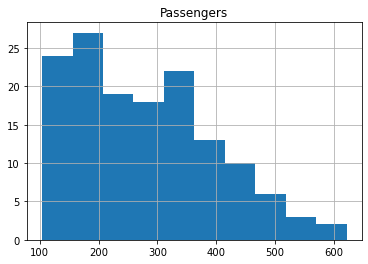

In [6]:
# Histogram
dataset.hist(bins=10)

/Users/israel/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


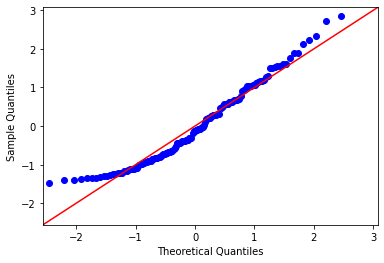

In [7]:
sm.qqplot(dataset.Passengers, fit=True, line="45")
plt.show()

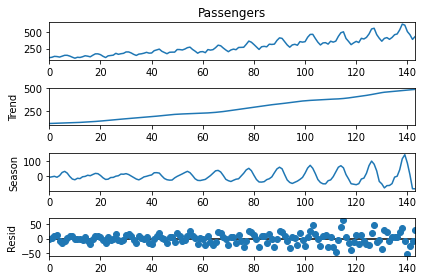

In [8]:
# STL decomposition
from statsmodels.tsa.seasonal import STL

stl = STL(dataset.Passengers, period=13, seasonal=7)
res = stl.fit()
fig = res.plot()

We can see that the time series is not stationary since the mean is not constant (we have trend) and the variance is not constant (the seasonal effect change over time)

In [9]:
# fix random seed for reproducibility
#tf.random.set_seed(7)

### Time series models

In [10]:
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size], dataset[train_size:len(dataset)]

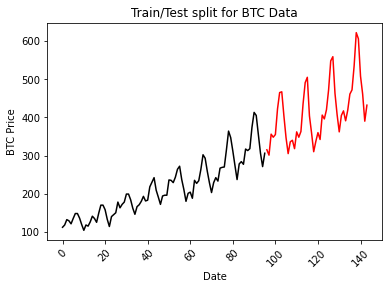

In [11]:
plt.plot(train, color = "black")
plt.plot(test, color = "red")
plt.ylabel('BTC Price')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("Train/Test split for BTC Data")
plt.show()

In [12]:
y = train['Passengers']

### AR

https://campus.datacamp.com/courses/time-series-analysis-in-python/putting-it-all-together-5?ex=8

/Users/israel/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/israel/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


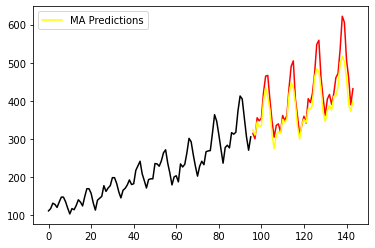

In [13]:
#  Fit the data to an AR(2) model and print AIC:
AR1model = ARIMA(y, order = (50, 0, 0))
AR1model = AR1model.fit()

y_pred = AR1model.get_forecast(len(test.index))
y_pred_df = y_pred.conf_int(alpha = 0.05) 
y_pred_df["Predictions"] = AR1model.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
y_pred_df.index = test.index
y_pred_out_ar1 = y_pred_df["Predictions"] 

plt.plot(train, color = "black")
plt.plot(test, color = "red")
plt.plot(y_pred_out_ar1, color='yellow', label = 'MA Predictions')
plt.legend()

In [14]:
ar_rmse = np.sqrt(mean_squared_error(test["Passengers"].values, y_pred_df["Predictions"]))
print("RMSE: ",ar_rmse)

RMSE:  38.262962713446726


### MA

/Users/israel/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/israel/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


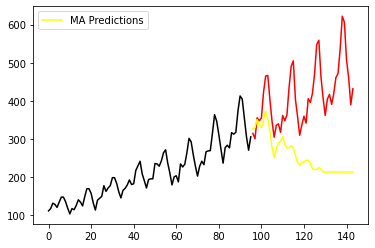

In [15]:
MAmodel = ARIMA(y, order = (0, 0, 35))
MAmodel = MAmodel.fit()

y_pred = MAmodel.get_forecast(len(test.index))
y_pred_df = y_pred.conf_int(alpha = 0.05) 
y_pred_df["Predictions"] = MAmodel.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
y_pred_df.index = test.index
y_pred_out_ma = y_pred_df["Predictions"] 

plt.plot(train, color = "black")
plt.plot(test, color = "red")
plt.plot(y_pred_out_ma, color='yellow', label = 'MA Predictions')
plt.legend()

In [16]:
arma_rmse = np.sqrt(mean_squared_error(test["Passengers"].values, y_pred_df["Predictions"]))
print("RMSE: ",arma_rmse)

RMSE:  187.02159420107878


### ARMA

/Users/israel/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/israel/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/israel/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


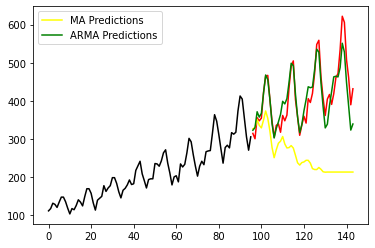

In [17]:
ARMAmodel = ARIMA(y, order = (40, 0, 20))

ARMAmodel = ARMAmodel.fit()

y_pred = ARMAmodel.get_forecast(len(test.index))
y_pred_df = y_pred.conf_int(alpha = 0.05) 
y_pred_df["Predictions"] = ARMAmodel.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
y_pred_df.index = test.index
y_pred_out_arma = y_pred_df["Predictions"] 

plt.plot(train, color = "black")
plt.plot(test, color = "red")
plt.plot(y_pred_out_ma, color='yellow', label = 'MA Predictions')
plt.plot(y_pred_out_arma, color='green', label = 'ARMA Predictions')
plt.legend()

In [18]:
arma_rmse = np.sqrt(mean_squared_error(test["Passengers"].values, y_pred_df["Predictions"]))
print("RMSE: ",arma_rmse)

RMSE:  36.254518718060055


### ARIMA

/Users/israel/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/israel/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


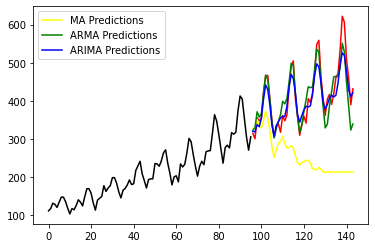

In [19]:
ARIMAmodel = ARIMA(y, order = (10, 2, 2))
ARIMAmodel = ARIMAmodel.fit()

y_pred = ARIMAmodel.get_forecast(len(test.index))
y_pred_df = y_pred.conf_int(alpha = 0.05) 
y_pred_df["Predictions"] = ARIMAmodel.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
y_pred_df.index = test.index
y_pred_out_arima = y_pred_df["Predictions"] 

plt.plot(train, color = "black")
plt.plot(test, color = "red")
plt.plot(y_pred_out_ma, color='yellow', label = 'MA Predictions')
plt.plot(y_pred_out_arma, color='green', label = 'ARMA Predictions')
plt.plot(y_pred_out_arima, color='blue', label = 'ARIMA Predictions')
plt.legend()

In [20]:
from sklearn.metrics import mean_squared_error

arma_rmse = np.sqrt(mean_squared_error(test["Passengers"].values, y_pred_df["Predictions"]))
print("RMSE: ",arma_rmse)

RMSE:  30.843052004038412


### SARIMA

/Users/israel/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/israel/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.34389D+00    |proj g|=  6.18343D-01


 This problem is unconstrained.



At iterate    5    f=  2.95272D+00    |proj g|=  2.36375D-02

At iterate   10    f=  2.82907D+00    |proj g|=  7.74845D-02

At iterate   15    f=  2.81398D+00    |proj g|=  9.99071D-03

At iterate   20    f=  2.81187D+00    |proj g|=  6.88760D-04

At iterate   25    f=  2.81143D+00    |proj g|=  1.56853D-02

At iterate   30    f=  2.80955D+00    |proj g|=  8.63475D-04

At iterate   35    f=  2.80948D+00    |proj g|=  3.38575D-03

At iterate   40    f=  2.80911D+00    |proj g|=  4.83201D-03

At iterate   45    f=  2.80825D+00    |proj g|=  2.42402D-02

At iterate   50    f=  2.80623D+00    |proj g|=  9.77313D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/Users/israel/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


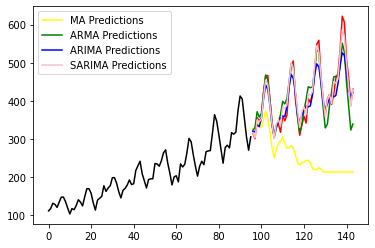

In [21]:
SARIMAXmodel = SARIMAX(y, order = (2, 2, 2), seasonal_order=(2,2,2,12))
SARIMAXmodel = SARIMAXmodel.fit()

y_pred = SARIMAXmodel.get_forecast(len(test.index))
y_pred_df = y_pred.conf_int(alpha = 0.05) 
y_pred_df["Predictions"] = SARIMAXmodel.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
y_pred_df.index = test.index
y_pred_out_sarima = y_pred_df["Predictions"] 

plt.plot(train, color = "black")
plt.plot(test, color = "red")
plt.plot(y_pred_out_ma, color='yellow', label = 'MA Predictions')
plt.plot(y_pred_out_arma, color='green', label = 'ARMA Predictions')
plt.plot(y_pred_out_arima, color='blue', label = 'ARIMA Predictions')
plt.plot(y_pred_out_sarima, color='pink', label = 'SARIMA Predictions')
plt.legend()

In [22]:
sarima_rmse = np.sqrt(mean_squared_error(test["Passengers"].values, y_pred_df["Predictions"]))
print("RMSE: ",sarima_rmse)

RMSE:  17.59450448620972


### Data preparation for NN

In [23]:
dataset = dataset.values
dataset = dataset.astype('float32')

In [24]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [25]:
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

96 48


In [26]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [27]:
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [28]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

#### Vanilla RNN

In [29]:
# create and fit the LSTM network
model = Sequential()
model.add(SimpleRNN(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=0)

2022-11-09 14:34:00.749945: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [30]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

2/2 [==============================] - 0s 2ms/step


In [31]:
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
orig_trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
orig_testY = scaler.inverse_transform([testY])

In [32]:
# calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(orig_trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(orig_testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 22.74 RMSE
Test Score: 61.70 RMSE


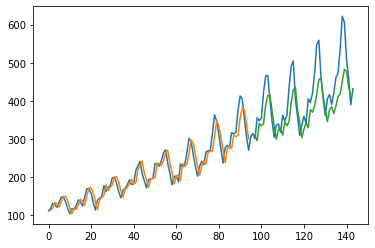

In [33]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

#### LSTM

In [34]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=0)

In [35]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

2/2 [==============================] - 0s 2ms/step


In [36]:
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
orig_trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
orig_testY = scaler.inverse_transform([testY])

In [37]:
# calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(orig_trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(orig_testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 22.60 RMSE
Test Score: 55.22 RMSE


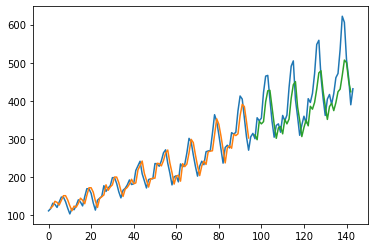

In [38]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

#### GRU

In [ ]:
# create and fit the LSTM network
model = Sequential()
model.add(GRU(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=0)

In [ ]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

In [ ]:
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
orig_trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
orig_testY = scaler.inverse_transform([testY])

In [ ]:
# calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(orig_trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(orig_testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

In [ ]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

#### Encoder decoder model

In [ ]:
# Sequence to Sequence Model with one encoder layer and one decoder layer.
encoder_inputs = tf.keras.layers.Input(shape=(look_back, 1))
encoder_l1 = tf.keras.layers.LSTM(20, return_state=True)
encoder_outputs1 = encoder_l1(encoder_inputs)
encoder_states1 = encoder_outputs1[1:]

#
decoder_inputs = tf.keras.layers.RepeatVector(1)(encoder_outputs1[0])
decoder_l1 = tf.keras.layers.LSTM(20, return_sequences=True)(decoder_inputs,initial_state = encoder_states1)
decoder_outputs1 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(1))(decoder_l1)

#
model_e1d1 = tf.keras.models.Model(encoder_inputs,decoder_outputs1)

reduce_lr = tf.keras.callbacks.LearningRateScheduler(lambda x: 1e-3 * 0.90 ** x)
model_e1d1.compile(optimizer=tf.keras.optimizers.Adam(), loss='mean_squared_error')

model_e1d1.fit(trainX, trainY,epochs=35,batch_size=1,verbose=0,callbacks=[reduce_lr])

In [ ]:
# Sequence to Sequence Model with two encoder layers and two decoder layers.
encoder_inputs = tf.keras.layers.Input(shape=(look_back, 1))
encoder_l1 = tf.keras.layers.LSTM(40,return_sequences = True, return_state=True)
encoder_outputs1 = encoder_l1(encoder_inputs)
encoder_states1 = encoder_outputs1[1:]
encoder_l2 = tf.keras.layers.LSTM(40, return_state=True)
encoder_outputs2 = encoder_l2(encoder_outputs1[0])
encoder_states2 = encoder_outputs2[1:]

#
decoder_inputs = tf.keras.layers.RepeatVector(1)(encoder_outputs2[0])
decoder_l1 = tf.keras.layers.LSTM(40, return_sequences=True)(decoder_inputs,initial_state = encoder_states1)
decoder_l2 = tf.keras.layers.LSTM(40, return_sequences=True)(decoder_l1,initial_state = encoder_states2)
decoder_outputs2 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(1))(decoder_l2)

#
model_e1d1 = tf.keras.models.Model(encoder_inputs,decoder_outputs2)

reduce_lr = tf.keras.callbacks.LearningRateScheduler(lambda x: 1e-3 * 0.90 ** x)
model_e1d1.compile(optimizer=tf.keras.optimizers.Adam(), loss='mean_squared_error')

model_e1d1.fit(trainX, trainY,epochs=25,batch_size=1,verbose=0,callbacks=[reduce_lr])

In [ ]:
# make predictions
trainPredict = model_e1d1.predict(trainX)
testPredict = model_e1d1.predict(testX)

In [ ]:
# invert predictions
trainPredict = scaler.inverse_transform(np.squeeze(trainPredict, axis=(2,)))
orig_trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(np.squeeze(testPredict, axis=(2,)))
orig_testY = scaler.inverse_transform([testY])

In [ ]:
# calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(orig_trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(orig_testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

In [ ]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

#### Transormer

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
head_size=16
num_heads=4
dropout=0.01
ff_dim=1
mlp_units=[8]
mlp_dropout=0.4
d_model = 12

input_shape = trainX.shape[1:]

inputs = keras.Input(shape=input_shape)
# Transformer Encoder
x = layers.LayerNormalization(epsilon=1e-2)(inputs)
x = layers.MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(x, x)
res = x + inputs

# Feed Forward Part
x = layers.LayerNormalization(epsilon=1e-2)(res)
x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)

x = x + res

x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
for dim in mlp_units:
    x = layers.Dense(dim, activation="relu")(x)

model = keras.Model(inputs, x)
model.compile(loss="mean_squared_error", optimizer=keras.optimizers.Adam(learning_rate=0.01), metrics=["mae"],)

callbacks = [keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]

model.fit(trainX, trainY,validation_split=0.1,epochs=200,batch_size=2,callbacks=callbacks,)

In [ ]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

In [ ]:
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
orig_trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
orig_testY = scaler.inverse_transform([testY])

In [ ]:
# calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(orig_trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(orig_testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

In [ ]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = np.reshape(trainPredict[:, 0], (-1, 1))
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = np.reshape(testPredict[:, 0], (-1, 1))
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()